# Dimensionality Reduction

In [1]:
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline
from utility_funcitons import *
from feature_selection import *
import pandas as pd 
import numpy as np


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_features, test_features, feature_names = featurize(train, test, 'tfidf_glove')

y_train = np.where(train.label.values == 'clickbait', 1, 0)
y_test = np.where(test.label.values == 'clickbait', 1, 0)

Starts with number....
Clickbait Phrases....
Clickbait re....
Num dots....
Text Features....
Punctuation....
Word ratios....
Sentiment Scores....
Readability Scores....



Glove.....



DONE!


In [2]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1

score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)

X = sparse.vstack((train_features, test_features))
test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, n_jobs = 4, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)


def fit_n_times(model, x_train, y_train, x_test, y_test, n_iters = 10):
    metrics = np.zeros(5)
    for _ in range(n_iters):
        model.fit(x_train, y_train)
        y_test_prob = model.predict_proba(x_test)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, verbose = False, return_metrics = True)
    metrics /=10
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))



In [3]:
from sklearn.feature_selection import SelectKBest


selector = SelectKBest(k = 80)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test)

F1: 0.983 | Pr: 0.981 | Re: 0.986 | AUC: 0.998 | Accuracy: 0.983 



SGDClassifier(loss='log', n_jobs=-1)

In [4]:
from utility_funcitons import *

f1_scores = []

for k in tqdm_notebook(range(1, train_features.shape[1])):
    selector = SelectKBest(k = k)
    train_features_selected = selector.fit_transform(train_features, y_train)
    test_features_selected = selector.transform(test_features)
    f1_scores.append(run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2, return_f1 = True, verbose = 0))
f1_scores = np.array(f1_scores)

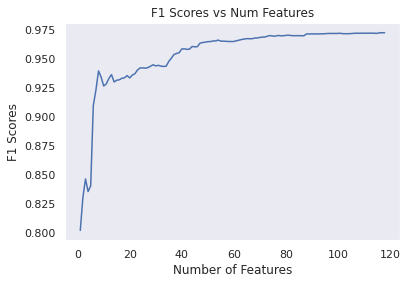

In [15]:
# Now let's plot the F1 scores:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

x = list(range(1, train_features.shape[1]))
plt.plot(x, f1_scores)
plt.xlabel('Number of Features')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Num Features')
plt.grid()
plt.show()



In [6]:
print(np.argmax(f1_scores) + 1)


117


In [16]:
selector = SelectKBest(k = 60)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.965 | Pr: 0.962 | Re: 0.968 | AUC: 0.994 | Accuracy: 0.965 



SGDClassifier(alpha=0.01, loss='log', n_jobs=-1)

In [8]:
# we can use get_support() to find out exactly which features were selected
np.array(feature_names)[selector.get_support()]


array(['starts_with_number', 'mean_word_length', 'easy_words_ratio',
       'stop_words_ratio', 'clickbait_subs_ratio',
       'nonclickbait_subs_ratio', 'dale_chall_readability_score',
       'glove_1', 'glove_3', 'glove_4', 'glove_6', 'glove_10', 'glove_14',
       'glove_17', 'glove_19', 'glove_27', 'glove_32', 'glove_33',
       'glove_35', 'glove_39', 'glove_40', 'glove_45', 'glove_46',
       'glove_47', 'glove_51', 'glove_53', 'glove_56', 'glove_61',
       'glove_62', 'glove_65', 'glove_72', 'glove_74', 'glove_77',
       'glove_79', 'glove_85', 'glove_87', 'glove_89', 'glove_90',
       'glove_92', 'glove_93', 'glove_94', 'glove_95', 'glove_96',
       'glove_97', 'glove_98'], dtype='<U28')

### Select Percentile

In [9]:
from sklearn.feature_selection import SelectPercentile

f1_scores = []

for percentage in tqdm_notebook(range(1, 101)):
    selector = SelectPercentile(percentile = percentage)
    train_features_selected = selector.fit_transform(train_features, y_train)
    test_features_selected = selector.transform(test_features)
    f1_scores.append(run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2, return_f1 = True, verbose = 0))
f1_scores = np.array(f1_scores)

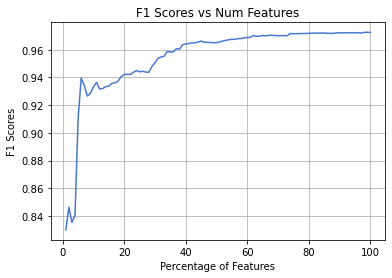

In [10]:
# Now let's plot the F1 scores:
import matplotlib.pyplot as plt

%matplotlib inline

x = list(range(1, 101))
plt.plot(x, f1_scores)
plt.xlabel('Percentage of Features')
plt.ylabel('F1 Scores')
plt.title('F1 Scores vs Num Features')
plt.grid()
plt.show()


In [11]:
print(np.argmax(f1_scores) + 1)

99


In [12]:
selector = SelectPercentile(percentile = 37)
train_features_selected = selector.fit_transform(train_features, y_train)
test_features_selected = selector.transform(test_features)
run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

F1: 0.961 | Pr: 0.956 | Re: 0.965 | AUC: 0.993 | Accuracy: 0.961 



SGDClassifier(alpha=0.01, loss='log', n_jobs=-1)

In [13]:
np.array(feature_names)[selector.get_support()]

array(['starts_with_number', 'mean_word_length', 'easy_words_ratio',
       'stop_words_ratio', 'clickbait_subs_ratio',
       'nonclickbait_subs_ratio', 'dale_chall_readability_score',
       'glove_1', 'glove_3', 'glove_4', 'glove_6', 'glove_10', 'glove_14',
       'glove_17', 'glove_19', 'glove_27', 'glove_32', 'glove_33',
       'glove_35', 'glove_39', 'glove_40', 'glove_45', 'glove_46',
       'glove_47', 'glove_51', 'glove_53', 'glove_56', 'glove_61',
       'glove_65', 'glove_72', 'glove_74', 'glove_77', 'glove_79',
       'glove_85', 'glove_87', 'glove_89', 'glove_90', 'glove_92',
       'glove_93', 'glove_94', 'glove_95', 'glove_96', 'glove_97',
       'glove_98'], dtype='<U28')

# Recursive Feature Elimination

In [14]:
# Since we have a hold out Test set that we would like to use - Let's create a `PredefinedSplit`
from sklearn.model_selection import PredefinedSplit

X = sparse.vstack((train_features, test_features))
test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]     # We need to label -1 for the train set and 0 for test set
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

In [15]:
from sklearn.feature_selection import RFECV

log_reg = SGDClassifier(loss = 'log', alpha = 1e-3)

selector = RFECV(log_reg, scoring = 'f1', n_jobs = -1, cv = ps, verbose = 1)
selector.fit(X, y)

Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting 

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=SGDClassifier(alpha=0.001, loss='log'), n_jobs=-1, scoring='f1',
      verbose=1)

In [16]:
# Now lets select the best features and check the performance
train_features_selected = selector.transform(train_features)
test_features_selected = selector.transform(test_features)

run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-1)

F1: 0.961 | Pr: 0.953 | Re: 0.969 | AUC: 0.993 | Accuracy: 0.961 



SGDClassifier(alpha=0.1, loss='log', n_jobs=-1)

In [17]:
# Lets check which features were selected 
print('Number of features selected : {}'.format(selector.n_features_))
np.array(feature_names)[selector.support_]

Number of features selected : 87


array(['starts_with_number', 'clickbait_phrases', 'num_dots',
       'mean_word_length', 'length_in_chars', 'easy_words_ratio',
       'stop_words_ratio', 'contractions_ratio', 'hyperbolic_ratio',
       'clickbait_subs_ratio', 'nonclickbait_subs_ratio',
       'sentiment_compound', 'dale_chall_readability_score',
       'num_punctuations', 'glove_0', 'glove_1', 'glove_2', 'glove_3',
       'glove_4', 'glove_5', 'glove_6', 'glove_10', 'glove_12',
       'glove_13', 'glove_14', 'glove_15', 'glove_16', 'glove_17',
       'glove_18', 'glove_19', 'glove_21', 'glove_24', 'glove_25',
       'glove_27', 'glove_29', 'glove_32', 'glove_33', 'glove_35',
       'glove_36', 'glove_39', 'glove_40', 'glove_41', 'glove_43',
       'glove_45', 'glove_46', 'glove_47', 'glove_50', 'glove_51',
       'glove_52', 'glove_53', 'glove_54', 'glove_55', 'glove_56',
       'glove_57', 'glove_58', 'glove_59', 'glove_60', 'glove_61',
       'glove_65', 'glove_66', 'glove_68', 'glove_70', 'glove_71',
       'glove

# Sequential Forward Selection

In [17]:
# # Note: MLxtend provides the SFS Implementation
# from mlxtend.feature_selection import SequentialFeatureSelector

# log_reg = SGDClassifier(loss = 'log', alpha = 1e-2)

# selector = SequentialFeatureSelector(log_reg, k_features = 'best', floating = True, cv = ps, scoring = 'f1', verbose = 1, n_jobs = -1) # k_features = 'best' returns the best subset of features
# selector.fit(X.tocsr(), y)

In [18]:
# # Now lets select the best features and check the performance
# train_features_selected = selector.transform(train_features.tocsr())
# test_features_selected = selector.transform(test_features.tocsr())

# run_log_reg(train_features_selected, test_features_selected, y_train, y_test, alpha = 1e-2)

In [19]:
# print('Num of features selected : {}'.format(len(selector.k_feature_idx_)))
# np.array(feature_names)[list(selector.k_feature_idx_)]

# Decomposition

In [20]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
sns.set()
svd = TruncatedSVD(train_features.shape[1] - 1)
svd.fit(train_features)

TruncatedSVD(n_components=118)

Text(0.5, 1.0, 'Number of Components vs Explained Variance')

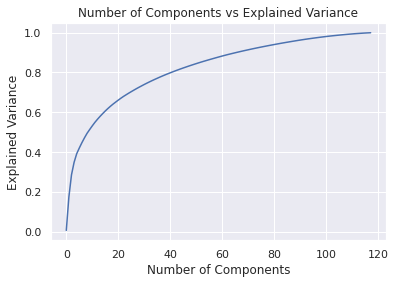

In [21]:
# We want to find the number of components that explains most of the variance
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Number of Components vs Explained Variance')

In [22]:
# Lets go ahead and reduce dimensionality to 50

svd = TruncatedSVD(117)
train_featurse_decomposed = svd.fit_transform(train_features)
test_featurse_decomposed = svd.transform(test_features)

run_log_reg(train_featurse_decomposed, test_featurse_decomposed, y_train, y_test, alpha = 1e-1)

F1: 0.958 | Pr: 0.952 | Re: 0.965 | AUC: 0.992 | Accuracy: 0.958 



SGDClassifier(alpha=0.1, loss='log', n_jobs=-1)

# Stacking Classifier with Feature Selection

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


batch_size = 16
epochs = 50

simple_nn = Sequential()
simple_nn.add(Dense(150, activation='relu', input_shape=(60,)))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(100, activation='relu'))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(1, activation='sigmoid'))

simple_nn.summary()

simple_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('./saved_models', monitor = 'val_accuracy', verbose = 1, save_best_only=True)
history = simple_nn.fit(train_features_selected.todense(), y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [checkpoint],
                    validation_data=(test_features_selected.todense(), y_test))

simple_nn = load_model('./saved_models')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 150)               9150      
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 24,351
Trainable params: 24,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
612/625 [============================>.

Epoch 23/50
593/625 [===========================>..] - ETA: 0s - loss: 0.0537 - accuracy: 0.9805
Epoch 00023: val_accuracy did not improve from 0.98245
625/625 [==============================] - 2s 3ms/step - loss: 0.0534 - accuracy: 0.9805 - val_loss: 0.0524 - val_accuracy: 0.9822
Epoch 24/50
586/625 [===========================>..] - ETA: 0s - loss: 0.0507 - accuracy: 0.9817
Epoch 00024: val_accuracy did not improve from 0.98245
625/625 [==============================] - 1s 2ms/step - loss: 0.0507 - accuracy: 0.9820 - val_loss: 0.0484 - val_accuracy: 0.9820
Epoch 25/50
600/625 [===========================>..] - ETA: 0s - loss: 0.0503 - accuracy: 0.9827
Epoch 00025: val_accuracy improved from 0.98245 to 0.98265, saving model to ./saved_models
INFO:tensorflow:Assets written to: ./saved_models/assets
625/625 [==============================] - 2s 4ms/step - loss: 0.0501 - accuracy: 0.9827 - val_loss: 0.0502 - val_accuracy: 0.9826
Epoch 26/50
625/625 [==============================] - ETA

Epoch 50/50
604/625 [===========================>..] - ETA: 0s - loss: 0.0408 - accuracy: 0.9848
Epoch 00050: val_accuracy did not improve from 0.98360
625/625 [==============================] - 1s 2ms/step - loss: 0.0406 - accuracy: 0.9848 - val_loss: 0.0520 - val_accuracy: 0.9827


In [24]:
y_pred_prob = simple_nn.predict(test_features_selected.todense())
print_model_metrics(y_test, y_pred_prob)

F1: 0.984 | Pr: 0.982 | Re: 0.987 | AUC: 0.998 | Accuracy: 0.984 



In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log', alpha = 0.1, penalty = 'l2', l1_ratio = 0.5)
svm = SVC(C = 1, kernel = 'rbf', probability = True)
nb = MultinomialNB(alpha = 10000, class_prior = [0.5, 0.5])
knn = KNeighborsClassifier(n_neighbors = 31, weights = 'distance', n_jobs = -1)
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 2, max_depth = 15,  n_jobs = -1)
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.3, max_depth = 1, n_jobs = -1)

model_dict = dict(zip(['LR', 'SVM', 'NB', 'KNN', 'RF', 'XGB'], [lr, svm, nb, knn, rf, xgb]))

for model_name, model in model_dict.items():
    print('Training {}'.format(model_name))
    model.fit(train_features_selected, y_train)

model_weights = {'KNN': 0.7866810233035141,
                 'LR': 0.8036572275670447,
                 'NB': 0.9102009774357307,
                 'RF': 0.1559824350958057,
                 'SVM': 0.9355079606348642,
                 'XGB': 0.33469066125332436,
                 'simple_nn': 0.000545264707939086}


y_pred_prob = 0

for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob)


Training LR
Training SVM
Training NB
Training KNN
Training RF
Training XGB
F1: 0.985 | Pr: 0.985 | Re: 0.985 | AUC: 0.998 | Accuracy: 0.985 



In [26]:
def run_voting_clf(model_weights):
    #result_list, model_weights = data
    
    y_pred_prob = 0

    for model_name, model in model_dict.items():
        y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

    #y_pred_prob += (simple_nn.get_preds(ds_type = DatasetType.Valid)[0].numpy()[:,0] * model_weights['simple_nn'])
    y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
    y_pred_prob /= sum(model_weights.values())
    f1 = print_model_metrics(y_test, y_pred_prob, return_metrics = True, verbose = 0)[0]
    return {'loss' : -f1, 'status' : STATUS_OK}


In [27]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

trials = Trials()
model_weights = fmin(run_voting_clf,
    space= {
        'LR' : hp.uniform('LR', 0, 1),
        'SVM' : hp.uniform('SVM', 0, 1),
        'NB' : hp.uniform('NB', 0, 1),
        'KNN' : hp.uniform('KNN', 0, 1),
        'RF' : hp.uniform('RF', 0, 1),
        'XGB' : hp.uniform('XGB', 0, 1),
        'simple_nn' : hp.uniform('simple_nn', 0, 1),


    },
    algo=tpe.suggest,
    max_evals=100,
    trials = trials)

100%|██████████| 100/100 [27:58<00:00, 16.79s/trial, best loss: -0.9860367348981532]


In [28]:
model_weights

{'KNN': 0.5804790416002688,
 'LR': 5.05551901532203e-05,
 'NB': 0.008970931024758932,
 'RF': 0.3043966543598309,
 'SVM': 0.2143509108920118,
 'XGB': 0.004287828597133725,
 'simple_nn': 0.559584081384372}

F1: 0.986 | Pr: 0.986 | Re: 0.986 | AUC: 0.999 | Accuracy: 0.986 



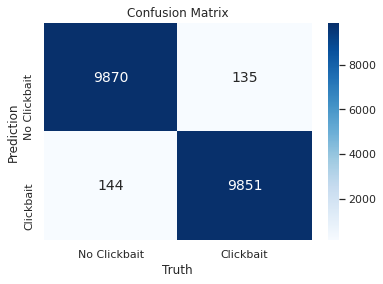

In [29]:
y_pred_prob = 0

for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features_selected)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features_selected.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob, confusion = True)

In [30]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob, pos_label = 1)
    
#Find the threshold value that gives the best F1 Score
best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

# Calulcate predictions based on the threshold value
y_test_pred = np.where(y_pred_prob > best_threshold, 1, 0)
misclassified_idx = y_test != y_test_pred
high_confidence_indices = np.argsort(y_pred_prob[misclassified_idx])[-10:]

for idx in high_confidence_indices:
    print('Title : {}'.format(test[misclassified_idx].title.values[idx]))
    print('Label : {}'.format(test[misclassified_idx].label.values[idx]))
    print('Predicted Probability : {}'.format(y_pred_prob[misclassified_idx][idx]))
    print('-' * 10)

Title : Cellphone Abilities That Go Untapped
Label : not-clickbait
Predicted Probability : 0.9667401766684104
----------
Title : What Is Facebook Actually Worth?
Label : not-clickbait
Predicted Probability : 0.9681435999530588
----------
Title : Candace Parker Is Putting Family First
Label : not-clickbait
Predicted Probability : 0.9693334530466561
----------
Title : Big Movie Studios May Be Mightier Than Ever
Label : not-clickbait
Predicted Probability : 0.9729300437918226
----------
Title : No Snickering: That Road Sign Means Something Else
Label : not-clickbait
Predicted Probability : 0.9738313451970713
----------
Title : My Swings With Annika
Label : not-clickbait
Predicted Probability : 0.9773002986635099
----------
Title : If You Want to Text Obama, Do It Before Jan. 20
Label : not-clickbait
Predicted Probability : 0.9844523781568715
----------
Title : A Little Rugby With Your Cross-Dressing?
Label : not-clickbait
Predicted Probability : 0.9862391112441472
----------
Title : What 

In [31]:
test[test.label.values == 'not-clickbait'].sample(10).title.values

array(['A Casino Rises in the Place of a Fallen Steel Giant',
       'Museum Gunman a Longtime Foe of Government',
       "Southwest Airlines flight diverts due to 'rapid decompression in the cabin'",
       'NATO intensifies attack on Libya',
       'Turkish Premier Reaches Out in an Important Kurdish City',
       'Technology developed to detect fake drugs quickly',
       "Hugo Chavez meets Iran's Imam Khamenei",
       'Somalia in danger of famine',
       'Myanmar Again Closes Trial of Dissident, Aung San Suu Kyi',
       'Morning-after pill to be made available to 17-year-olds, U.S. federal judge rules'],
      dtype=object)

# Tuning after Feature Selection

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1

score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)



# Since we want to use a predefined Test/Val set, we'll use PredefinedSplit and pass it as the CV parameter
# We need to merge both the datasets and label 0 for test and -1 for the train set

X = sparse.vstack((train_features_selected, test_features_selected))
test_fold = [-1 for _ in range(train_features_selected.shape[0])] + [0 for _ in range(test_features_selected.shape[0])]
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, n_jobs = -1, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)

# Run log reg n times and average the metrics
def fit_n_times(model, x_train, y_train, x_test, y_test, n_iters = 10):
    metrics = np.zeros(5)
    for _ in range(n_iters):
        model.fit(x_train, y_train)
        y_test_prob = model.predict_proba(x_test)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, verbose = False, return_metrics = True)
    metrics /=10
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    

from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log')
lr_params = {'alpha' : [10**(-x) for x in range(7)],
             'penalty' : ['l1', 'l2', 'elasticnet'],
             'l1_ratio' : [0.15, 0.25, 0.5, 0.75]}

best_params, best_f1 = run_grid_search(lr, lr_params, X, y)

print('LR Best Parameters : {}'.format(best_params))



from sklearn.svm import SVC

svm = SVC(probability = True)
svm_params = {'C' : [10**(x) for x in range(-1,4)],
             'kernel' : ['poly', 'rbf', 'linear'],
             'degree' : [2, 3]}

best_params, best_f1 = run_grid_search(svm, svm_params, X, y)

print('SVM Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(class_prior = [0.5, 0.5])
nb_params = {'alpha' : [10**(x) for x in range(6)]}


best_params, best_f1 = run_grid_search(nb, nb_params, X, y)

print('NB Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs = -1)

knn_params = { 'n_neighbors' : [3, 5, 7, 9, 15, 31], 
               'weights' : ['uniform', 'distance']
}

best_params, best_f1 = run_grid_search(knn, knn_params, X, y)
print('KNN Best Parameters : {}'.format(best_params))

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs = -1)

rf_params = { 'n_estimators' : [10, 100, 250, 500, 1000], 
               'max_depth' : [None, 3, 7, 15],
               'min_samples_split' : [2, 5, 15]
}

best_params, best_f1 = run_grid_search(rf, rf_params, X, y)

print('RF Best Parameters : {}'.format(best_params))

from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs = 1)

xgb_params = { 'n_estimators' : [10, 100, 200, 500], 
               'max_depth' : [1, 2, 3, 7],
               'learning_rate' : [0.1, 0.2, 0.01, 0.3],
               'reg_alpha' : [0, 0.1, 0.2]
}

best_params, best_f1 = run_grid_search(xgb, xgb_params, X, y)

print('XGB Best Parameters : {}'.format(best_params))